# Introduction

Here,We've used **CNN** to perform Image Classification on the Brain Tumor dataset.<br>
Since this dataset is small, if we train a neural network to it, it won't really give us a good result.<br>
Therefore, We're going to use **Transfer Learning** to train the model to get accurate results.

---

# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
from tqdm import tqdm

import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from PIL import Image
from IPython.display import display,clear_output

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
os.path.join('../input/brain-tumor-classification-mri','Training','glioma_tumor')

'../input/brain-tumor-classification-mri/Training/glioma_tumor'

# Data Preperation

In [4]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 89.14it/s]


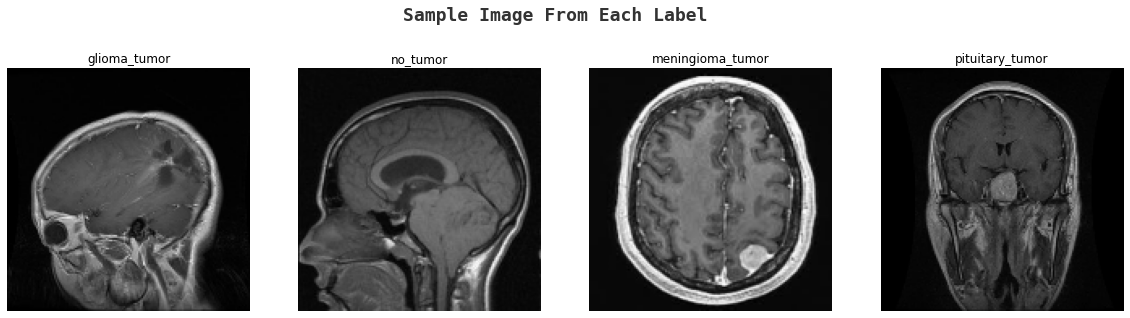

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

Dividing the dataset into **Training** and **Testing** sets.

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

print('We have {} total number of images for training'.format(len(X_train)))
print('We have {} total number of images for validation'.format(len(X_val)))

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

We have 2937 total number of images for training
We have 327 total number of images for validation


---

# Transfer Learning

In [7]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16711680/16705208 [==============================] - 0s 0us/step


In [8]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)


model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,
                             mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

history = model.fit(X_train,y_train,validation_split=0.1, epochs =3, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/3
83/83 [==============================] - 25s 155ms/step - loss: 0.7030 - accuracy: 0.7277 - val_loss: 0.3272 - val_accuracy: 0.8912

Epoch 00001: val_accuracy improved from -inf to 0.89116, saving model to effnet.h5
Epoch 2/3
83/83 [==============================] - 10s 117ms/step - loss: 0.1970 - accuracy: 0.9259 - val_loss: 0.2761 - val_accuracy: 0.8946

Epoch 00002: val_accuracy improved from 0.89116 to 0.89456, saving model to effnet.h5
Epoch 3/3
83/83 [==============================] - 10s 117ms/step - loss: 0.1104 - accuracy: 0.9657 - val_loss: 0.4240 - val_accuracy: 0.8844

Epoch 00003: val_accuracy did not improve from 0.89456


In [9]:
model.save('Miniproject.h5')

# Prediction

In [10]:
from sklearn.metrics import accuracy_score

preds = model.predict(X_val)
preds = np.argmax(preds,axis=1)
y_true = np.argmax(y_val,axis=1)
print('The accuracy score on validation data is {}'.format(accuracy_score(preds,y_true)))

The accuracy score on validation data is 0.8623853211009175


# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

Model Prediction : Glioma Tumor


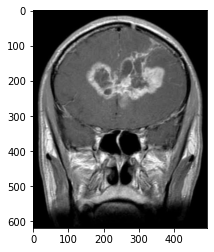

In [11]:
def Prediction(path):
    cv_img = cv2.imread(path)
    img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'Model Prediction : {p}')
    return cv_img
path = '../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(1).jpg'
img = Prediction(path)
plt.imshow(img);

# Inference 

In [12]:
from ipywidgets import widgets
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [13]:
import io
def UploadPrediction(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]
    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'Model Prediction : {p}')

In [14]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            UploadPrediction(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

# Conclusion

In this notebook, I performed Image Classification with the help of CNN using Transfer Learning which gave an accuracy of 92%.<br>